# Step 2 (Load dataset, EDA, and preprocess)

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import random
import kagglehub
from kagglehub import KaggleDatasetAdapter
import yaml
import collections
import numpy as np
from PIL import Image

In [ ]:
# kagglehub.dataset_download('slavkoprytula/aquarium-data-cots')

KaggleApiHTTPError: 403 Client Error.

You don't have permission to access resource at URL: https://www.kaggle.com/datasets/slavkoprytula/aquarium-data-cots/versions/1. Please make sure you are authenticated if you are trying to access a private resource or a resource requiring consent.

In [14]:
# !mkdir datasets
# !mv /kaggle/input/aquarium-data-cots/aquarium_pretrain /content/datasets/
# !cat ./datasets/aquarium_pretrain/README.dataset.txt

## Load Dataset and Show Samples

### Load Dataset Configuration


In [15]:
dataset_path = './datasets/aquarium_pretrain'
data_yaml_path = os.path.join(dataset_path, 'data.yaml')

with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

class_names = data_config['names']
num_classes = data_config['nc']

print(f"Class Names: {class_names}")
print(f"Number of Classes: {num_classes}")

Class Names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
Number of Classes: 7


### Prepare Training Data Paths


In [16]:
train_images_dir = os.path.join(dataset_path, data_config['train'].replace('../', ''))
train_labels_dir = os.path.join(dataset_path, data_config['train'].replace('images', 'labels').replace('../', ''))

train_image_paths = []
train_label_paths = []

for img_filename in os.listdir(train_images_dir):
    if img_filename.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(train_images_dir, img_filename)
        label_filename = img_filename.rsplit('.', 1)[0] + '.txt'
        label_path = os.path.join(train_labels_dir, label_filename)

        if os.path.exists(label_path):
            train_image_paths.append(image_path)
            train_label_paths.append(label_path)

print(f"Total training images found: {len(train_image_paths)}")
print(f"Total training labels found: {len(train_label_paths)}")

Total training images found: 448
Total training labels found: 448


### Define Bounding Box Visualization Function

In [17]:
def plot_bounding_boxes(image_path, label_path, class_names):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Convert BGR to RGB for Matplotlib display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    H, W, _ = img_rgb.shape

    # Load label data
    try:
        with open(label_path, 'r') as f:
            labels = f.readlines()
    except FileNotFoundError:
        print(f"Error: Label file not found at {label_path}")
        plt.imshow(img_rgb)
        plt.title(os.path.basename(image_path))
        plt.axis('off')
        plt.show()
        return

    for label in labels:
        parts = list(map(float, label.strip().split()))
        class_id = int(parts[0])
        center_x_norm, center_y_norm, width_norm, height_norm = parts[1:]

        # Convert normalized coordinates to absolute pixel coordinates
        center_x = int(center_x_norm * W)
        center_y = int(center_y_norm * H)
        box_width = int(width_norm * W)
        box_height = int(height_norm * H)

        # Calculate top-left and bottom-right corners
        x1 = int(center_x - box_width / 2)
        y1 = int(center_y - box_height / 2)
        x2 = int(center_x + box_width / 2)
        y2 = int(center_y + box_height / 2)

        # Draw rectangle
        color = (0, 255, 0) # Green in RGB
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)

        # Put class label
        class_name = class_names[class_id]
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7
        font_thickness = 2
        text_size = cv2.getTextSize(class_name, font, font_scale, font_thickness)[0]
        text_x = x1
        text_y = y1 - 10 if y1 - 10 > 10 else y1 + text_size[1] + 10 # Adjust text position
        cv2.putText(img_rgb, class_name, (text_x, text_y), font, font_scale, color, font_thickness, cv2.LINE_AA)

    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

### Display Random Training Images with Bounding Boxes


Displaying 10 random training images with bounding boxes...
Image: IMG_3162_jpeg_jpg.rf.ca22f639cc30b9f768ad729155f6ad6e.jpg, Label: IMG_3162_jpeg_jpg.rf.ca22f639cc30b9f768ad729155f6ad6e.txt


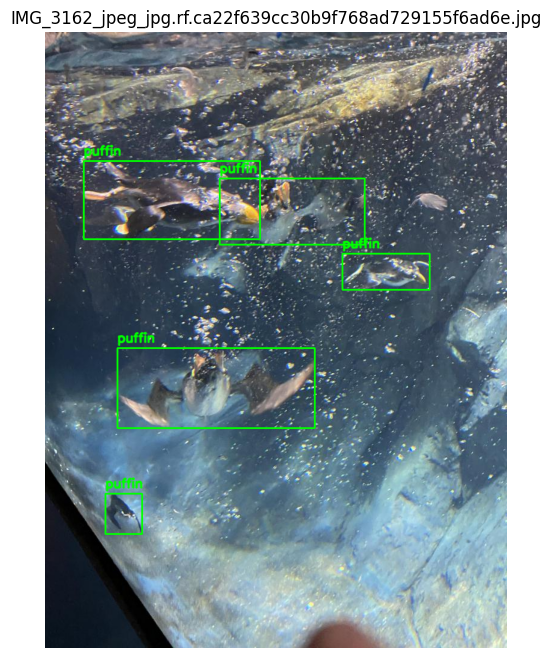

Image: IMG_2584_jpeg_jpg.rf.fdf498ef5b1b000a6c51d15dc29ad33a.jpg, Label: IMG_2584_jpeg_jpg.rf.fdf498ef5b1b000a6c51d15dc29ad33a.txt


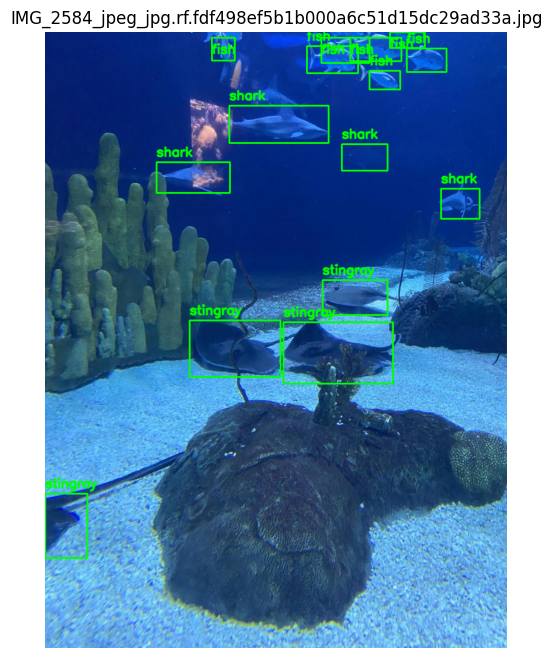

Image: IMG_2483_jpeg_jpg.rf.4cce5bab03a29d47dde28e0ffa71a3a0.jpg, Label: IMG_2483_jpeg_jpg.rf.4cce5bab03a29d47dde28e0ffa71a3a0.txt


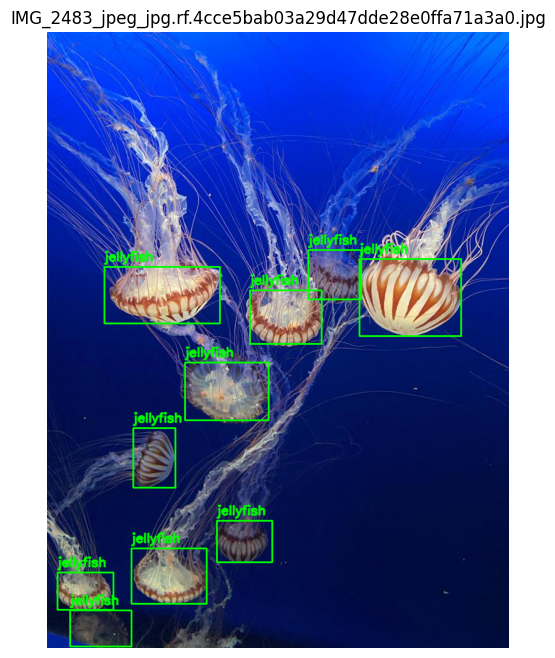

Image: IMG_8376_jpg.rf.f129d46d1c4ae234b8aebe69ea012d64.jpg, Label: IMG_8376_jpg.rf.f129d46d1c4ae234b8aebe69ea012d64.txt


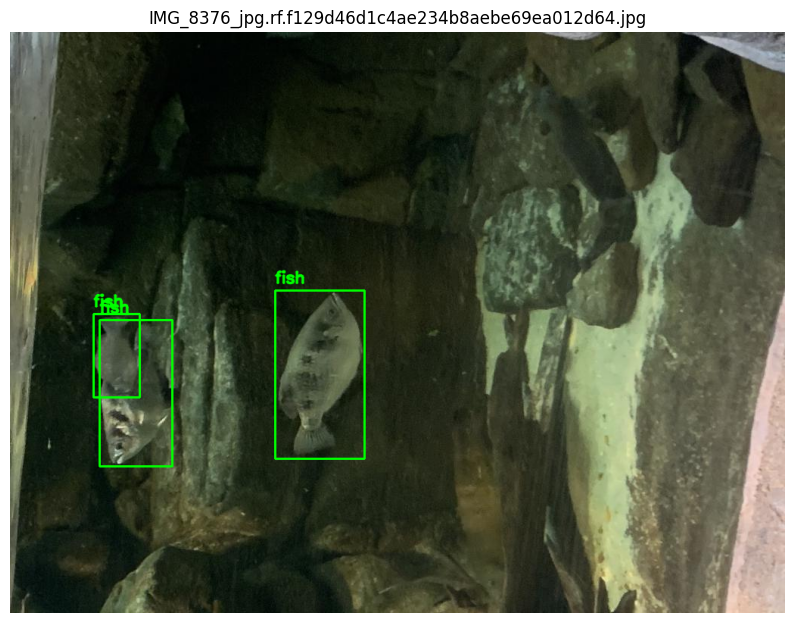

Image: IMG_2335_jpeg_jpg.rf.fee7aabbe3a95b58fa737bf4537ded6f.jpg, Label: IMG_2335_jpeg_jpg.rf.fee7aabbe3a95b58fa737bf4537ded6f.txt


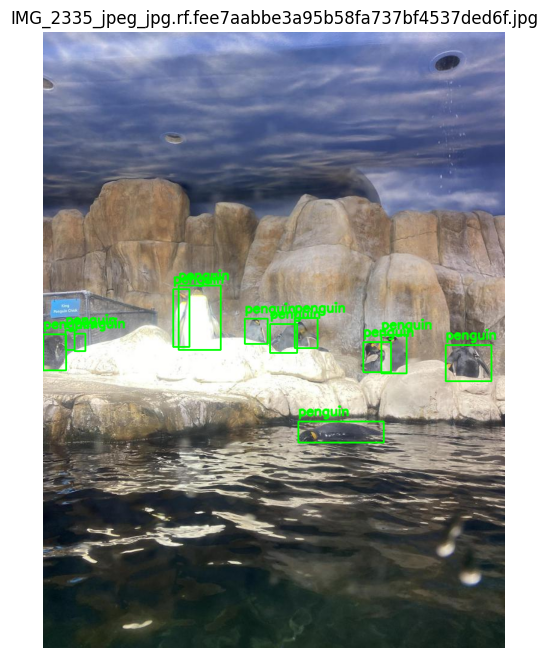

Image: IMG_8430_jpg.rf.710d601448bbe45e4e357906d7c73427.jpg, Label: IMG_8430_jpg.rf.710d601448bbe45e4e357906d7c73427.txt


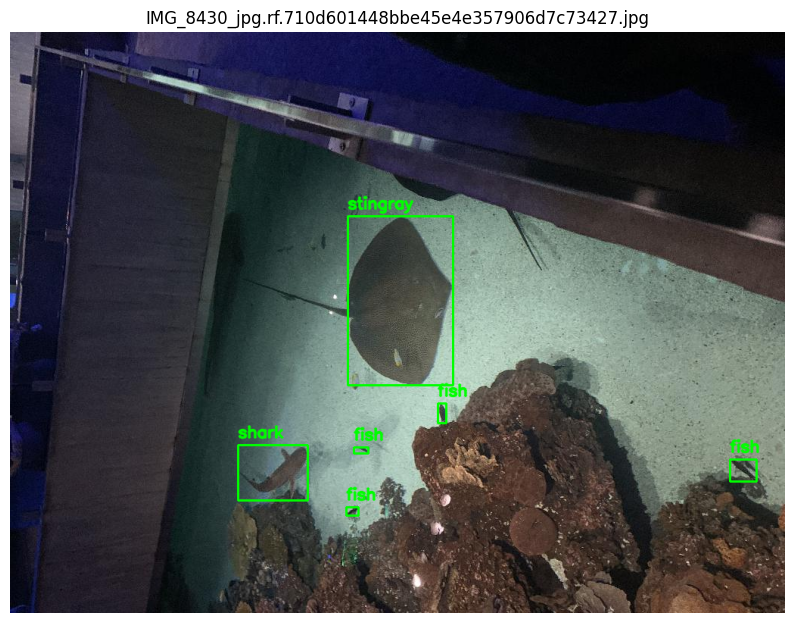

Image: IMG_8517_MOV-4_jpg.rf.82cc2fd5812151d35ce655a5b25f5215.jpg, Label: IMG_8517_MOV-4_jpg.rf.82cc2fd5812151d35ce655a5b25f5215.txt


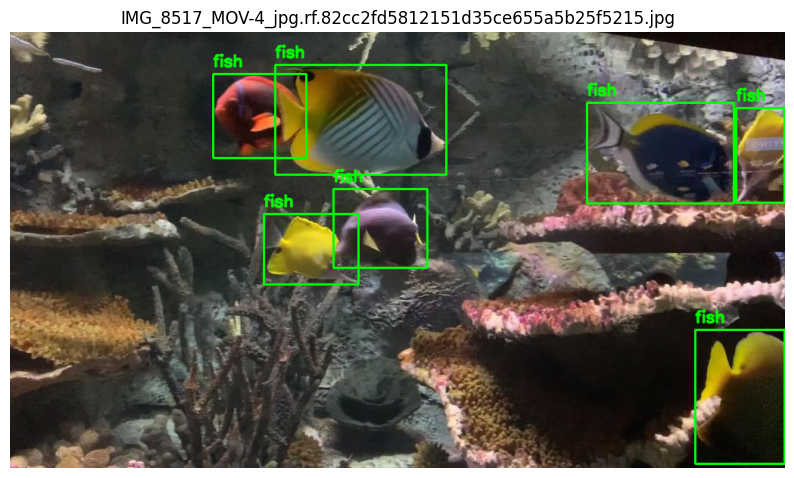

Image: IMG_2363_jpeg_jpg.rf.c646c1cefead3cafbda9956f065dbe6a.jpg, Label: IMG_2363_jpeg_jpg.rf.c646c1cefead3cafbda9956f065dbe6a.txt


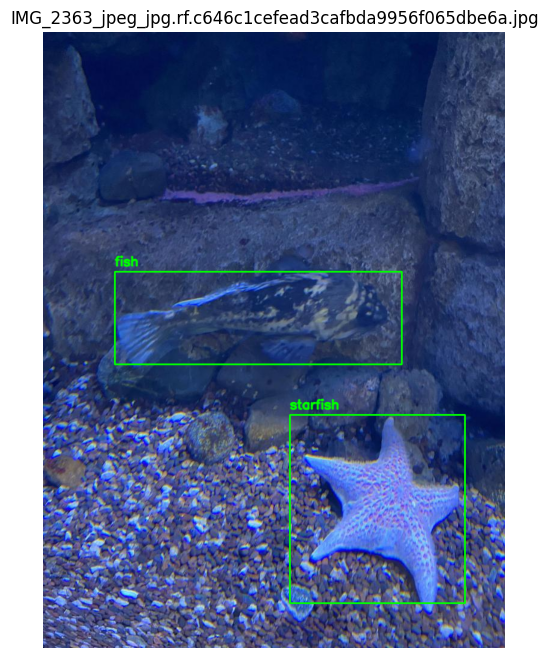

Image: IMG_8599_MOV-0_jpg.rf.3bd4fd78a244fdb4e48556896c70de74.jpg, Label: IMG_8599_MOV-0_jpg.rf.3bd4fd78a244fdb4e48556896c70de74.txt


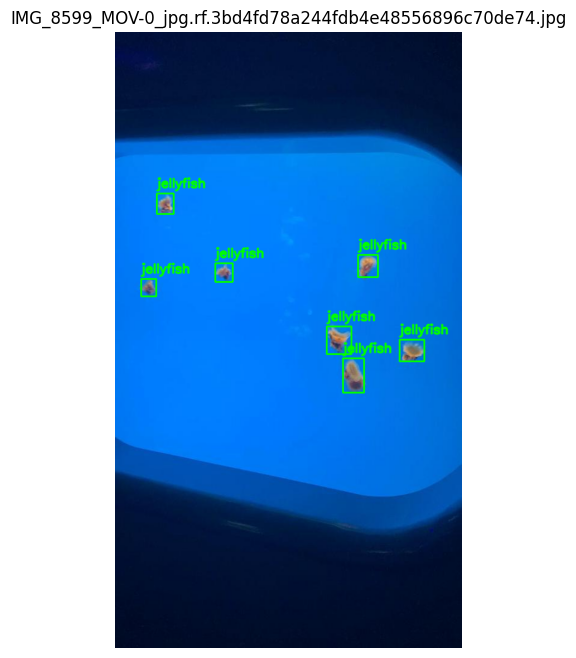

Image: IMG_3172_jpeg_jpg.rf.ce1a948fee49ecf8e542db885541bcab.jpg, Label: IMG_3172_jpeg_jpg.rf.ce1a948fee49ecf8e542db885541bcab.txt


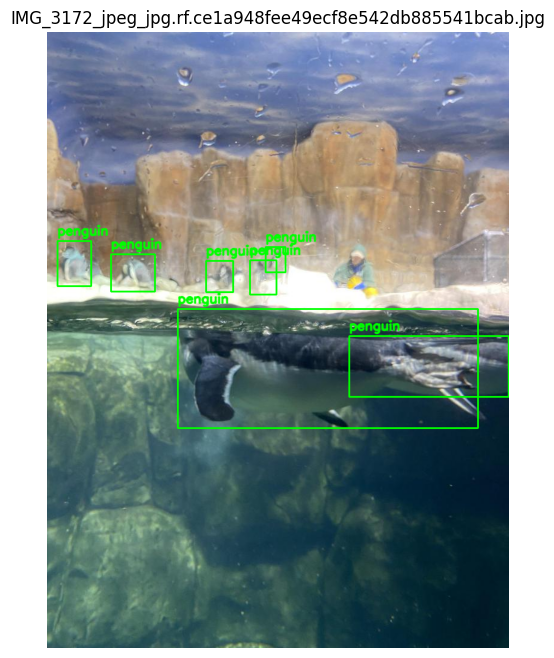

In [18]:
num_samples = 10
random_indices = random.sample(range(len(train_image_paths)), min(num_samples, len(train_image_paths)))

print(f"Displaying {len(random_indices)} random training images with bounding boxes...")

for i in random_indices:
    image_path = train_image_paths[i]
    label_path = train_label_paths[i]

    print(f"Image: {os.path.basename(image_path)}, Label: {os.path.basename(label_path)}")
    plot_bounding_boxes(image_path, label_path, class_names)

## EDA

### Parse Label Data for Statistics

In [19]:
all_class_ids = []
objects_per_image = []
all_bbox_widths = []
all_bbox_heights = []
all_bbox_aspect_ratios = []

for img_path, lbl_path in zip(train_image_paths, train_label_paths):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not load image from {img_path}. Skipping.")
        continue

    H, W, _ = img.shape
    current_image_objects = 0

    try:
        with open(lbl_path, 'r') as f:
            labels = f.readlines()
    except FileNotFoundError:
        print(f"Warning: Label file not found at {lbl_path}. Skipping.")
        continue

    for label_line in labels:
        parts = list(map(float, label_line.strip().split()))
        class_id = int(parts[0])
        _, _, norm_width, norm_height = parts[1:]

        # Convert normalized width and height to absolute pixel values
        abs_width = norm_width * W
        abs_height = norm_height * H

        # Calculate aspect ratio
        aspect_ratio = abs_width / abs_height if abs_height != 0 else 0

        all_class_ids.append(class_id)
        all_bbox_widths.append(abs_width)
        all_bbox_heights.append(abs_height)
        all_bbox_aspect_ratios.append(aspect_ratio)
        current_image_objects += 1

    objects_per_image.append(current_image_objects)

print(f"Total class IDs extracted: {len(all_class_ids)}")
print(f"Total images processed for object counts: {len(objects_per_image)}")
print(f"Total bounding box widths extracted: {len(all_bbox_widths)}")
print(f"Total bounding box heights extracted: {len(all_bbox_heights)}")
print(f"Total bounding box aspect ratios extracted: {len(all_bbox_aspect_ratios)}")

Total class IDs extracted: 3324
Total images processed for object counts: 448
Total bounding box widths extracted: 3324
Total bounding box heights extracted: 3324
Total bounding box aspect ratios extracted: 3324


### Calculate and Visualize Some Statisitcs

In [20]:
class_image_counts = collections.defaultdict(int)

for lbl_path in train_label_paths:
    try:
        with open(lbl_path, 'r') as f:
            labels = f.readlines()
    except FileNotFoundError:
        print(f"Warning: Label file not found at {lbl_path}. Skipping.")
        continue

    # Get unique class IDs for the current image
    unique_class_ids_in_image = set()
    for label_line in labels:
        parts = list(map(float, label_line.strip().split()))
        class_id = int(parts[0])
        unique_class_ids_in_image.add(class_id)

    # Increment count for each unique class in this image
    for class_id in unique_class_ids_in_image:
        class_image_counts[class_id] += 1

print("Class Image Counts:")
for class_id, count in sorted(class_image_counts.items()):
    print(f"  Class {class_id} ({class_names[class_id]}): {count} images")

Class Image Counts:
  Class 0 (fish): 240 images
  Class 1 (jellyfish): 32 images
  Class 2 (penguin): 47 images
  Class 3 (puffin): 45 images
  Class 4 (shark): 134 images
  Class 5 (starfish): 37 images
  Class 6 (stingray): 91 images


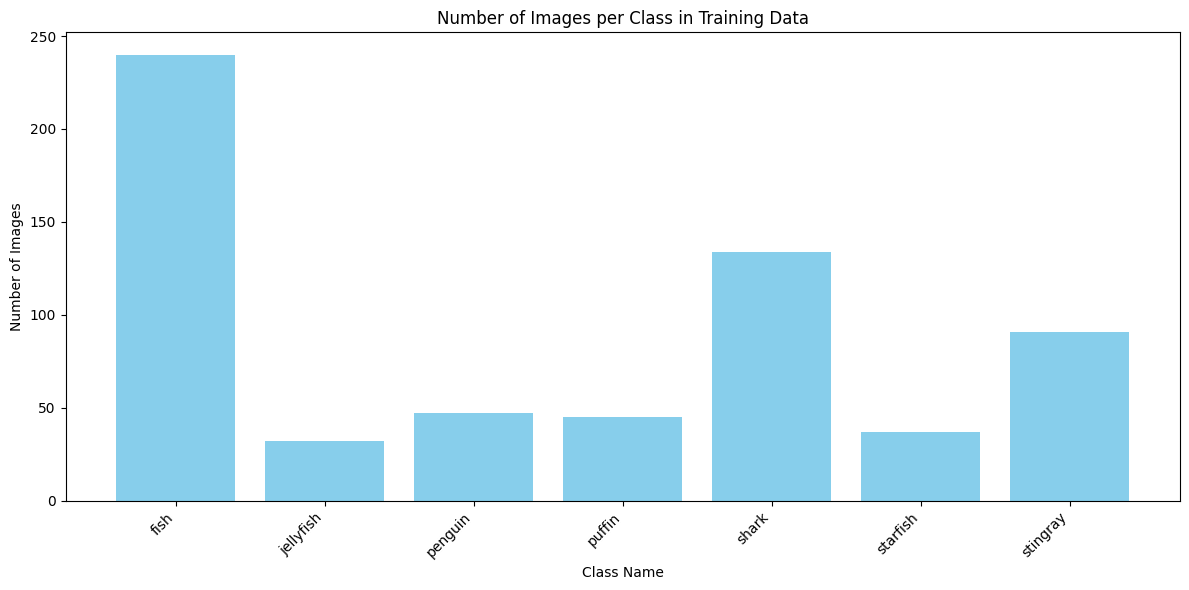

In [21]:
class_ids_sorted = sorted(class_image_counts.keys())
class_names_for_plot = [class_names[class_id] for class_id in class_ids_sorted]
image_counts_for_plot = [class_image_counts[class_id] for class_id in class_ids_sorted]

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(class_names_for_plot, image_counts_for_plot, color='skyblue')

plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Data')

plt.xticks(rotation=45, ha='right')

# Ensure layout is tight to prevent labels from overlapping
plt.tight_layout()

plt.show()


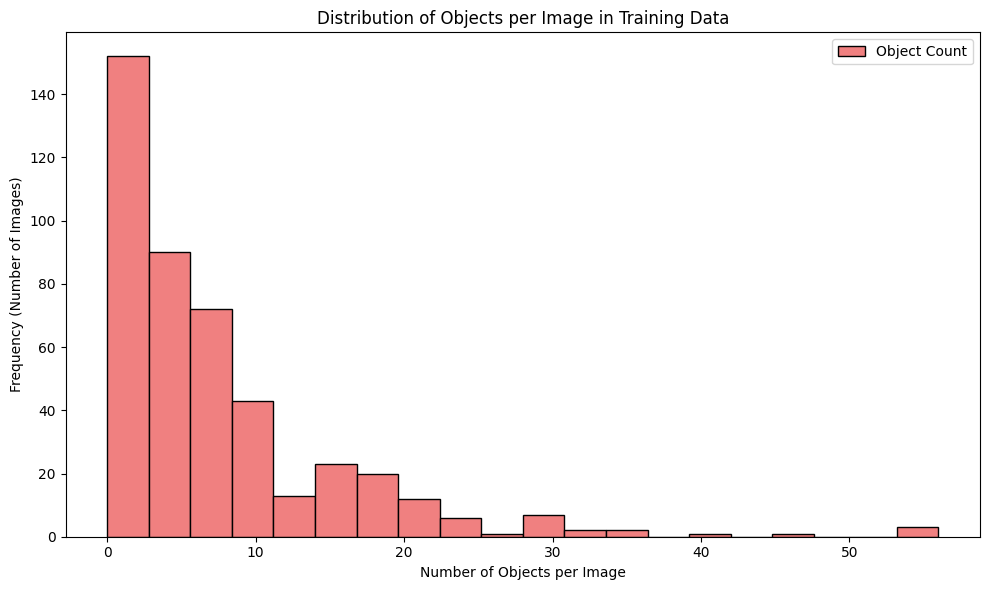

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(objects_per_image, bins=20, color='lightcoral', edgecolor='black')

plt.xlabel('Number of Objects per Image')
plt.ylabel('Frequency (Number of Images)')
plt.title('Distribution of Objects per Image in Training Data')

plt.legend(['Object Count'])

# Ensure layout is tight
plt.tight_layout()

plt.show()

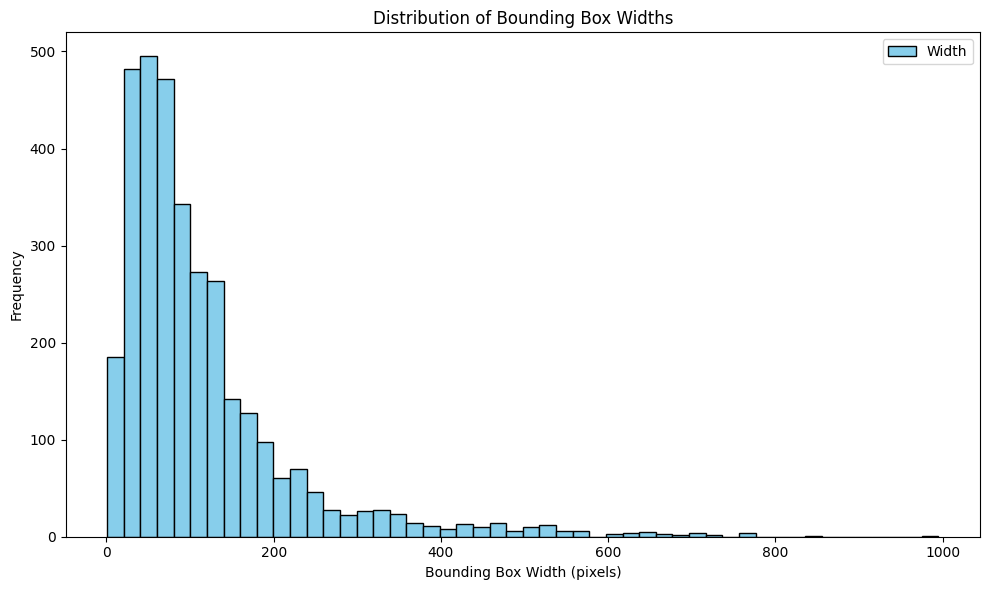

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(all_bbox_widths, bins=50, color='skyblue', edgecolor='black')

plt.xlabel('Bounding Box Width (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Bounding Box Widths')

plt.legend(['Width'])

# Ensure layout is tight
plt.tight_layout()

plt.show()

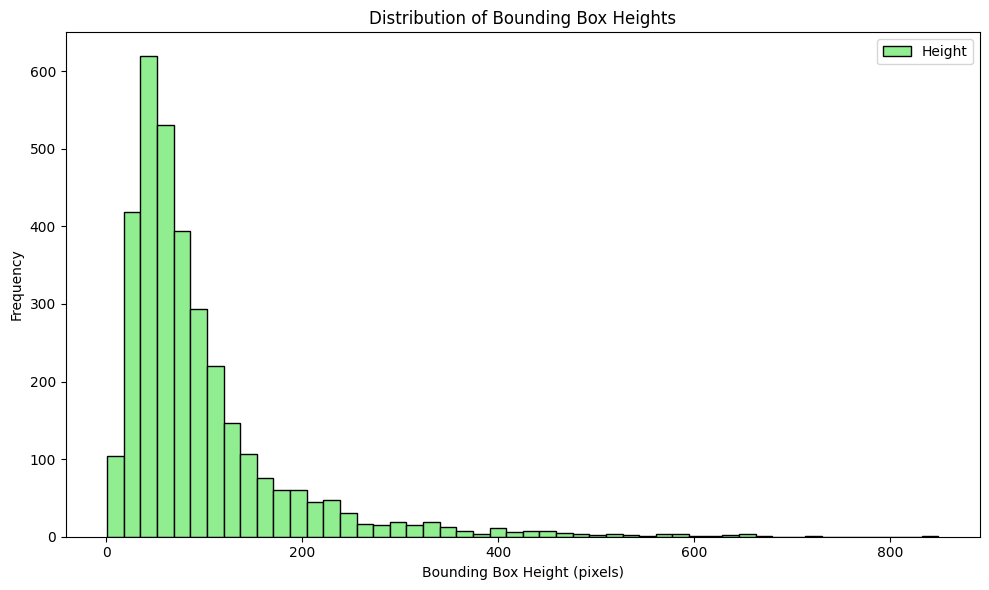

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(all_bbox_heights, bins=50, color='lightgreen', edgecolor='black')

plt.xlabel('Bounding Box Height (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Bounding Box Heights')

plt.legend(['Height'])

# Ensure layout is tight
plt.tight_layout()

plt.show()

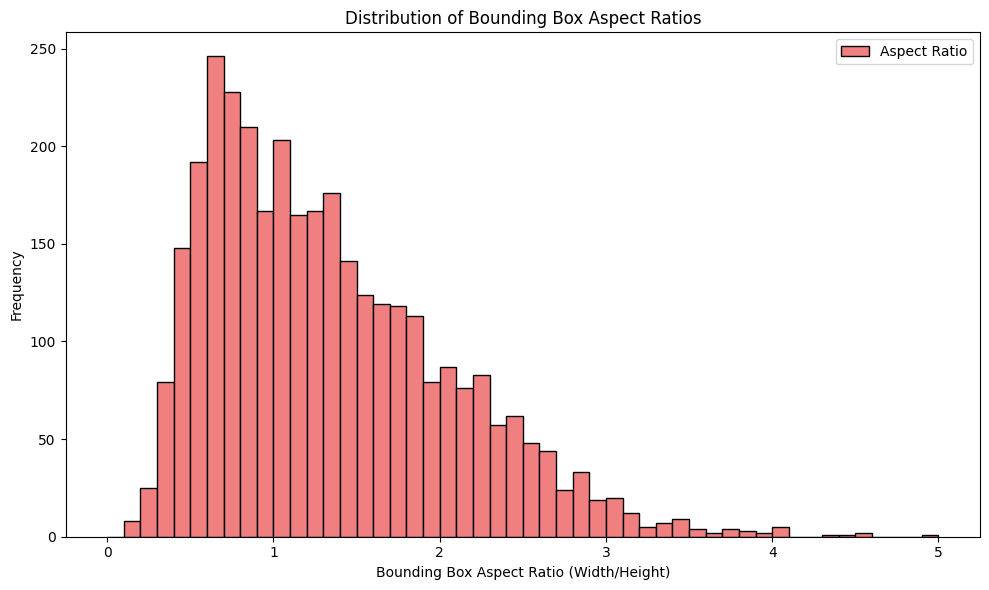

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(all_bbox_aspect_ratios, bins=50, color='lightcoral', edgecolor='black', range=(0, 5)) # Limiting range to focus on common aspect ratios

plt.xlabel('Bounding Box Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.title('Distribution of Bounding Box Aspect Ratios')

plt.legend(['Aspect Ratio'])

# Ensure layout is tight
plt.tight_layout()

plt.show()

## Data Preprocessing

### Check for Corrupted Images and Data Quality

In [ ]:
def check_image_quality(image_path, label_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return False, "Cannot load with OpenCV"
        
        h, w, c = img.shape
        if h < 10 or w < 10:
            return False, f"Image too small: {w}x{h}"
        
        if c != 3:
            return False, f"Invalid channels: {c} (expected 3)"
        
        # Check if image is completely black or white
        mean_val = np.mean(img)
        if mean_val < 5:
            return False, "Image too dark (nearly black)"
        if mean_val > 250:
            return False, "Image too bright (nearly white)"
        
        # Try loading with PIL as double check
        pil_img = Image.open(image_path)
        pil_img.verify()
        
        # Check label file
        if not os.path.exists(label_path):
            return False, "Label file missing"
        
        with open(label_path, 'r') as f:
            labels = f.readlines()
            if len(labels) == 0:
                return False, "Empty label file"
        
        return True, "OK"
    
    except Exception as e:
        return False, f"Exception: {str(e)}"

# Check all training images
print("Checking image and label quality...")
valid_image_paths = []
valid_label_paths = []
corrupted_images = []

for img_path, lbl_path in zip(train_image_paths, train_label_paths):
    is_valid, reason = check_image_quality(img_path, lbl_path)
    
    if is_valid:
        valid_image_paths.append(img_path)
        valid_label_paths.append(lbl_path)
    else:
        corrupted_images.append((img_path, reason))

print(f"\nQuality Check Results:")
print(f"  Total images checked: {len(train_image_paths)}")
print(f"  Valid images: {len(valid_image_paths)}")
print(f"  Corrupted/Invalid images: {len(corrupted_images)}")

if corrupted_images:
    print(f"\nCorrupted images found:")
    for img_path, reason in corrupted_images[:10]:  # Show first 10
        print(f"  - {os.path.basename(img_path)}: {reason}")
    if len(corrupted_images) > 10:
        print(f"  ... and {len(corrupted_images) - 10} more")

# Update training paths with valid images only
train_image_paths = valid_image_paths
train_label_paths = valid_label_paths

print(f"\nUpdated training set size: {len(train_image_paths)} images")

### Define Preprocessing Functions

In [ ]:
def resize_image_and_boxes(image, boxes, target_size=(800, 800), keep_aspect_ratio=True):
    h, w = image.shape[:2]
    target_w, target_h = target_size
    
    if keep_aspect_ratio:
        # Calculate scaling factor
        scale = min(target_w / w, target_h / h)
        new_w = int(w * scale)
        new_h = int(h * scale)
        
        resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        
        padded = np.zeros((target_h, target_w, 3), dtype=np.uint8)
        
        pad_x = (target_w - new_w) // 2
        pad_y = (target_h - new_h) // 2
        
        padded[pad_y:pad_y + new_h, pad_x:pad_x + new_w] = resized
        
        adjusted_boxes = []
        for box in boxes:
            class_id, x_center, y_center, box_w, box_h = box
            
            # Convert to pixel coordinates in original image
            x_center_px = x_center * w
            y_center_px = y_center * h
            box_w_px = box_w * w
            box_h_px = box_h * h
            
            # Scale and add padding
            x_center_new = (x_center_px * scale + pad_x)
            y_center_new = (y_center_px * scale + pad_y)
            box_w_new = box_w_px * scale
            box_h_new = box_h_px * scale
            
            # Normalize to new image size
            x_center_norm = x_center_new / target_w
            y_center_norm = y_center_new / target_h
            box_w_norm = box_w_new / target_w
            box_h_norm = box_h_new / target_h
            
            adjusted_boxes.append((class_id, x_center_norm, y_center_norm, box_w_norm, box_h_norm))
        
        return padded, adjusted_boxes, scale
    
    else:
        # Simple resize without maintaining aspect ratio
        resized = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
        # Boxes remain in normalized format, so they don't need adjustment
        return resized, boxes, (target_w / w, target_h / h)


def normalize_image(image, method='standard'):
    image = image.astype(np.float32)
    
    if method == 'standard':
        # Scale to [0, 1]
        normalized = image / 255.0
    
    elif method == 'imagenet':
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # ImageNet mean and std
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        normalized = (image_rgb / 255.0 - mean) / std
    
    elif method == 'minmax':
        # Min-max normalization
        min_val = np.min(image)
        max_val = np.max(image)
        if max_val - min_val > 0:
            normalized = (image - min_val) / (max_val - min_val)
        else:
            normalized = image / 255.0
    
    else:
        normalized = image / 255.0
    
    return normalized


def preprocess_image(image_path, label_path, target_size=(800, 800), 
                    normalize=True, normalization_method='standard'):
    
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Cannot load image: {image_path}")
    
    original_image = image.copy()
    
    # Load boxes
    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = list(map(float, line.strip().split()))
            boxes.append(tuple(parts))
    
    # Resize image and adjust boxes
    image, boxes, scale = resize_image_and_boxes(image, boxes, target_size=target_size, 
                                                keep_aspect_ratio=True)
    
    # Normalize
    if normalize:
        display_image = image.copy()  # Keep a copy for display
        image = normalize_image(image, method=normalization_method)
    else:
        display_image = image
    
    return image, boxes, original_image, display_image


print("Preprocessing functions defined successfully!")

### Visualize Preprocessing Effects

In [ ]:
def plot_preprocessing_comparison(image_path, label_path, target_size=(800, 800)):
    # Load original
    original = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Load labels
    with open(label_path, 'r') as f:
        labels = [list(map(float, line.strip().split())) for line in f.readlines()]
    
    # Preprocess
    processed, boxes_adjusted, _, display_image = preprocess_image(
        image_path, label_path, 
        target_size=target_size,
        apply_color_correction=True,
        normalize=False  # Don't normalize for visualization
    )
    
    processed_rgb = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)
    
    # Draw boxes on original
    H_orig, W_orig = original_rgb.shape[:2]
    for label in labels:
        class_id = int(label[0])
        x_c, y_c, w, h = label[1:]
        
        x1 = int((x_c - w/2) * W_orig)
        y1 = int((y_c - h/2) * H_orig)
        x2 = int((x_c + w/2) * W_orig)
        y2 = int((y_c + h/2) * H_orig)
        
        cv2.rectangle(original_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(original_rgb, class_names[class_id], (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Draw boxes on preprocessed
    H_proc, W_proc = processed_rgb.shape[:2]
    for box in boxes_adjusted:
        class_id = int(box[0])
        x_c, y_c, w, h = box[1:]
        
        x1 = int((x_c - w/2) * W_proc)
        y1 = int((y_c - h/2) * H_proc)
        x2 = int((x_c + w/2) * W_proc)
        y2 = int((y_c + h/2) * H_proc)
        
        cv2.rectangle(processed_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(processed_rgb, class_names[class_id], (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].imshow(original_rgb)
    axes[0].set_title(f'Original Image\nSize: {W_orig}x{H_orig}', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(processed_rgb)
    axes[1].set_title(f'Preprocessed Image\nSize: {W_proc}x{H_proc}\n(Resized + Color Enhanced)', 
                        fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


# Show preprocessing effects on random samples
print("Visualizing preprocessing effects on random samples...\n")
num_samples = 5
random_indices = random.sample(range(len(train_image_paths)), min(num_samples, len(train_image_paths)))

for idx in random_indices:
    img_path = train_image_paths[idx]
    lbl_path = train_label_paths[idx]
    print(f"\nSample: {os.path.basename(img_path)}")
    plot_preprocessing_comparison(img_path, lbl_path, target_size=(800, 800))

### Preprocessing Configuration Summary

In [ ]:
# Define preprocessing configuration
preprocessing_config = {
    'target_size': (800, 800),
    'keep_aspect_ratio': True,
    'apply_color_correction': True,
    'clahe_clip_limit': 2.0,
    'clahe_tile_size': (8, 8),
    'white_balance': True,
    'normalization_method': 'standard',  # 'standard', 'imagenet', or 'minmax'
    'remove_corrupted': True
}

# Print summary
print("=" * 60)
print("PREPROCESSING CONFIGURATION SUMMARY")
print("=" * 60)
print(f"\nData Quality:")
print(f"  - Total images in dataset: {len(train_image_paths) + len(corrupted_images)}")
print(f"  - Valid images: {len(train_image_paths)}")
print(f"  - Removed corrupted/invalid: {len(corrupted_images)}")
print(f"  - Retention rate: {len(train_image_paths)/(len(train_image_paths) + len(corrupted_images))*100:.2f}%")

print(f"\nImage Transformations:")
print(f"  - Target size: {preprocessing_config['target_size']}")
print(f"  - Keep aspect ratio: {preprocessing_config['keep_aspect_ratio']} (with padding)")
print(f"  - Interpolation: Linear (cv2.INTER_LINEAR)")

print(f"\nColor Correction (Underwater Enhancement):")
print(f"  - CLAHE enhancement: {preprocessing_config['apply_color_correction']}")
if preprocessing_config['apply_color_correction']:
    print(f"    - Clip limit: {preprocessing_config['clahe_clip_limit']}")
    print(f"    - Tile grid size: {preprocessing_config['clahe_tile_size']}")
print(f"  - White balance correction: {preprocessing_config['white_balance']}")

print(f"\nNormalization:")
print(f"  - Method: {preprocessing_config['normalization_method']}")
if preprocessing_config['normalization_method'] == 'standard':
    print(f"    - Range: [0, 1]")
elif preprocessing_config['normalization_method'] == 'imagenet':
    print(f"    - Mean: [0.485, 0.456, 0.406]")
    print(f"    - Std: [0.229, 0.224, 0.225]")

print(f"\nBounding Box Adjustments:")
print(f"  - Boxes adjusted for resize: Yes")
print(f"  - Boxes adjusted for padding: Yes")
print(f"  - Format maintained: YOLO (normalized center coords + width/height)")

print("\n" + "=" * 60)
print(f"Preprocessed dataset ready with {len(train_image_paths)} images!")
print("=" * 60)

### Analyze Image Statistics Before and After Preprocessing

In [ ]:
# Analyze a sample of images to compare before and after preprocessing
sample_size = min(50, len(train_image_paths))
sample_indices = random.sample(range(len(train_image_paths)), sample_size)

original_brightness = []
original_contrast = []
preprocessed_brightness = []
preprocessed_contrast = []

print(f"Analyzing {sample_size} images for quality metrics...")

for idx in sample_indices:
    img_path = train_image_paths[idx]
    lbl_path = train_label_paths[idx]
    
    # Original image
    orig_img = cv2.imread(img_path)
    if orig_img is not None:
        gray_orig = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
        original_brightness.append(np.mean(gray_orig))
        original_contrast.append(np.std(gray_orig))
    
    # Preprocessed image (without normalization for fair comparison)
    try:
        _, _, _, display_img = preprocess_image(img_path, lbl_path, 
                                                target_size=(800, 800),
                                                apply_color_correction=True,
                                                normalize=False)
        gray_proc = cv2.cvtColor(display_img, cv2.COLOR_BGR2GRAY)
        preprocessed_brightness.append(np.mean(gray_proc))
        preprocessed_contrast.append(np.std(gray_proc))
    except:
        pass

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Brightness comparison
axes[0, 0].hist(original_brightness, bins=30, alpha=0.7, color='blue', label='Original')
axes[0, 0].axvline(np.mean(original_brightness), color='blue', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Brightness (Mean Pixel Value)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'Original Image Brightness\nMean: {np.mean(original_brightness):.2f}')
axes[0, 0].legend()

axes[0, 1].hist(preprocessed_brightness, bins=30, alpha=0.7, color='green', label='Preprocessed')
axes[0, 1].axvline(np.mean(preprocessed_brightness), color='green', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Brightness (Mean Pixel Value)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Preprocessed Image Brightness\nMean: {np.mean(preprocessed_brightness):.2f}')
axes[0, 1].legend()

# Contrast comparison
axes[1, 0].hist(original_contrast, bins=30, alpha=0.7, color='blue', label='Original')
axes[1, 0].axvline(np.mean(original_contrast), color='blue', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Contrast (Std Dev of Pixel Values)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Original Image Contrast\nMean: {np.mean(original_contrast):.2f}')
axes[1, 0].legend()

axes[1, 1].hist(preprocessed_contrast, bins=30, alpha=0.7, color='green', label='Preprocessed')
axes[1, 1].axvline(np.mean(preprocessed_contrast), color='green', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Contrast (Std Dev of Pixel Values)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Preprocessed Image Contrast\nMean: {np.mean(preprocessed_contrast):.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "=" * 60)
print("IMAGE QUALITY METRICS COMPARISON")
print("=" * 60)
print(f"\nBrightness (mean pixel value):")
print(f"  Original:     {np.mean(original_brightness):.2f} ± {np.std(original_brightness):.2f}")
print(f"  Preprocessed: {np.mean(preprocessed_brightness):.2f} ± {np.std(preprocessed_brightness):.2f}")
print(f"  Improvement:  {((np.mean(preprocessed_brightness) - np.mean(original_brightness)) / np.mean(original_brightness) * 100):+.2f}%")

print(f"\nContrast (std dev of pixel values):")
print(f"  Original:     {np.mean(original_contrast):.2f} ± {np.std(original_contrast):.2f}")
print(f"  Preprocessed: {np.mean(preprocessed_contrast):.2f} ± {np.std(preprocessed_contrast):.2f}")
print(f"  Improvement:  {((np.mean(preprocessed_contrast) - np.mean(original_contrast)) / np.mean(original_contrast) * 100):+.2f}%")
print("=" * 60)

### Step 6: Create PyTorch Dataset Class with Preprocessing

This custom dataset class integrates all preprocessing steps and prepares the data for Faster R-CNN training.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class UnderwaterObjectDetectionDataset(Dataset):
    """
    Custom PyTorch Dataset for underwater object detection with preprocessing.
    Suitable for Faster R-CNN and other object detection models.
    """
    
    def __init__(self, image_paths, label_paths, class_names, config, transform=None):
        """
        Args:
            image_paths: List of image file paths
            label_paths: List of corresponding label file paths
            class_names: List of class names
            config: Preprocessing configuration dictionary
            transform: Optional additional torchvision transforms
        """
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.class_names = class_names
        self.config = config
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        lbl_path = self.label_paths[idx]
        
        # Load and preprocess image
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Cannot load image: {img_path}")
        
        # Load bounding boxes
        boxes = []
        labels = []
        with open(lbl_path, 'r') as f:
            for line in f.readlines():
                parts = list(map(float, line.strip().split()))
                class_id = int(parts[0])
                x_c, y_c, w, h = parts[1:]
                boxes.append([x_c, y_c, w, h])
                labels.append(class_id)
        
        # Resize image and adjust boxes
        target_size = self.config.get('target_size', (800, 800))
        boxes_tuples = [(labels[i], boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]) 
                       for i in range(len(boxes))]
        
        image, boxes_adjusted, _ = resize_image_and_boxes(
            image, boxes_tuples, 
            target_size=target_size,
            keep_aspect_ratio=self.config.get('keep_aspect_ratio', True)
        )
        
        # Convert boxes from YOLO format (center, normalized) to [x_min, y_min, x_max, y_max] format
        H, W = image.shape[:2]
        boxes_xyxy = []
        labels_adjusted = []
        
        for box in boxes_adjusted:
            class_id, x_c, y_c, w, h = box
            
            # Convert to pixel coordinates
            x_center = x_c * W
            y_center = y_c * H
            width = w * W
            height = h * H
            
            # Convert to [x_min, y_min, x_max, y_max]
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            x_max = x_center + width / 2
            y_max = y_center + height / 2
            
            boxes_xyxy.append([x_min, y_min, x_max, y_max])
            labels_adjusted.append(class_id)
        
        # Convert to tensors
        boxes_tensor = torch.as_tensor(boxes_xyxy, dtype=torch.float32)
        labels_tensor = torch.as_tensor(labels_adjusted, dtype=torch.int64)
        
        # Convert image to RGB and normalize
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Normalize image
        norm_method = self.config.get('normalization_method', 'standard')
        if norm_method == 'standard':
            image_normalized = image_rgb.astype(np.float32) / 255.0
        elif norm_method == 'imagenet':
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_normalized = (image_rgb.astype(np.float32) / 255.0 - mean) / std
        else:
            image_normalized = image_rgb.astype(np.float32) / 255.0
        
        # Convert to tensor (C, H, W) format
        image_tensor = torch.from_numpy(image_normalized).permute(2, 0, 1).float()
        
        # Apply additional transforms if provided
        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        # Create target dictionary (format expected by Faster R-CNN)
        target = {
            'boxes': boxes_tensor,
            'labels': labels_tensor,
            'image_id': torch.tensor([idx])
        }
        
        return image_tensor, target


# Create dataset instance
print("Creating dataset with preprocessing...")
train_dataset = UnderwaterObjectDetectionDataset(
    image_paths=train_image_paths,
    label_paths=train_label_paths,
    class_names=class_names,
    config=preprocessing_config
)

print(f"\nDataset created successfully!")
print(f"  - Total samples: {len(train_dataset)}")
print(f"  - Classes: {len(class_names)}")
print(f"  - Image shape after preprocessing: {preprocessing_config['target_size'] + (3,)}")  # (H, W, C)

# Test the dataset
print("\nTesting dataset by loading a sample...")
sample_img, sample_target = train_dataset[0]
print(f"  - Image tensor shape: {sample_img.shape}")
print(f"  - Number of objects: {len(sample_target['boxes'])}")
print(f"  - Boxes shape: {sample_target['boxes'].shape}")
print(f"  - Labels: {sample_target['labels']}")
print(f"  - Image value range: [{sample_img.min():.3f}, {sample_img.max():.3f}]")

print("\n✓ Dataset is ready for training!")